In [1]:
# Cell 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import joblib
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ===============================================================================
# Cell 2: Data Loading and Initial Exploration

def load_and_explore_data():
    """Load datasets and perform initial exploration"""
    
    # Load English dataset
    try:
        eng_df = pd.read_csv("English_spam.csv", encoding="latin-1")
        eng_df = eng_df[['v1', 'v2']]
        eng_df.columns = ['Label', 'Message']
        eng_df['Label'] = eng_df['Label'].map({'ham': 0, 'spam': 1})
        eng_df = eng_df.dropna(subset=['Label'])
        
        print(f"English dataset loaded: {len(eng_df)} samples")
        print(f"English Label distribution: {eng_df['Label'].value_counts().to_dict()}")
        
    except Exception as e:
        print(f"Error loading English dataset: {e}")
        # Create sample data for demonstration
        eng_df = pd.DataFrame({
            'Label': [0, 1, 0, 1, 0] * 100,
            'Message': ['Hi how are you?', 'Win money now!', 'Meeting at 3pm', 'Free offer!', 'Call me later'] * 100
        })
        print("Using sample English data for demonstration")
    
    # Load Sinhala dataset
    try:
        sin_df = pd.read_excel("sinhala spam.xlsx")
        sin_df.columns = ['Label', 'Message']
        sin_df.dropna(subset=['Label', 'Message'], inplace=True)
        sin_df['Label'] = sin_df['Label'].map({'ham': 0, 'spam': 1})
        sin_df.dropna(subset=['Label'], inplace=True)
        sin_df['Label'] = sin_df['Label'].astype(int)
        
        print(f"Sinhala dataset loaded: {len(sin_df)} samples")
        print(f"Sinhala Label distribution: {sin_df['Label'].value_counts().to_dict()}")
        
    except Exception as e:
        print(f"Error loading Sinhala dataset: {e}")
        # Create sample Sinhala data
        sin_df = pd.DataFrame({
            'Label': [0, 1, 0, 1, 0] * 50,
            'Message': ['කොහොමද?', 'නොමිලේ මුදල්!', 'හමුවීම', 'ත්‍යාගය!', 'කතා කරමු'] * 50
        })
        print("Using sample Sinhala data for demonstration")
    
    return eng_df, sin_df

# Load data
eng_df, sin_df = load_and_explore_data()

English dataset loaded: 5572 samples
English Label distribution: {0: 4825, 1: 747}
Sinhala dataset loaded: 653 samples
Sinhala Label distribution: {1: 525, 0: 128}


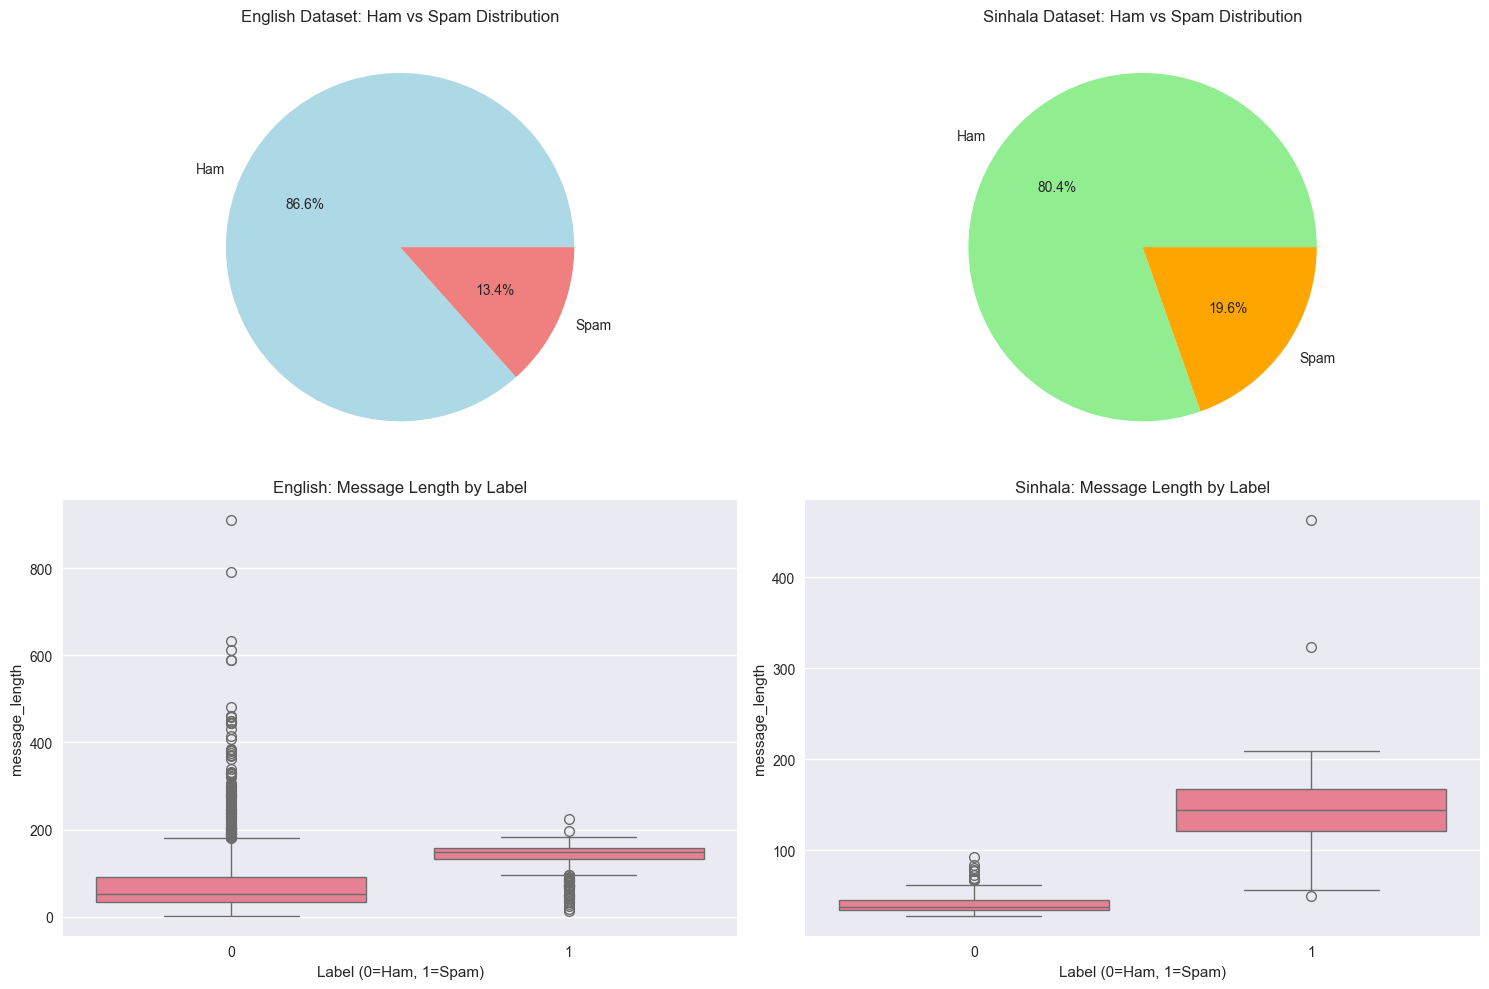


Dataset Statistics:
English - Total: 5572, Ham: 4825, Spam: 747
Sinhala - Total: 653, Ham: 128, Spam: 525


In [3]:

# ===============================================================================
# Cell 3: Data Visualization

def plot_data_distribution(eng_df, sin_df):
    """Create visualizations for data distribution"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # English dataset label distribution
    eng_counts = eng_df['Label'].value_counts()
    axes[0, 0].pie(eng_counts.values, labels=['Ham', 'Spam'], autopct='%1.1f%%', 
                   colors=['lightblue', 'lightcoral'])
    axes[0, 0].set_title('English Dataset: Ham vs Spam Distribution')
    
    # Sinhala dataset label distribution
    sin_counts = sin_df['Label'].value_counts()
    axes[0, 1].pie(sin_counts.values, labels=['Ham', 'Spam'], autopct='%1.1f%%',
                   colors=['lightgreen', 'orange'])
    axes[0, 1].set_title('Sinhala Dataset: Ham vs Spam Distribution')
    
    # Message length distribution for English
    eng_df['message_length'] = eng_df['Message'].str.len()
    sns.boxplot(data=eng_df, x='Label', y='message_length', ax=axes[1, 0])
    axes[1, 0].set_title('English: Message Length by Label')
    axes[1, 0].set_xlabel('Label (0=Ham, 1=Spam)')
    
    # Message length distribution for Sinhala
    sin_df['message_length'] = sin_df['Message'].str.len()
    sns.boxplot(data=sin_df, x='Label', y='message_length', ax=axes[1, 1])
    axes[1, 1].set_title('Sinhala: Message Length by Label')
    axes[1, 1].set_xlabel('Label (0=Ham, 1=Spam)')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nDataset Statistics:")
    print(f"English - Total: {len(eng_df)}, Ham: {eng_counts[0]}, Spam: {eng_counts[1]}")
    print(f"Sinhala - Total: {len(sin_df)}, Ham: {sin_counts[0]}, Spam: {sin_counts[1]}")

plot_data_distribution(eng_df, sin_df)

Extracting features for English dataset...


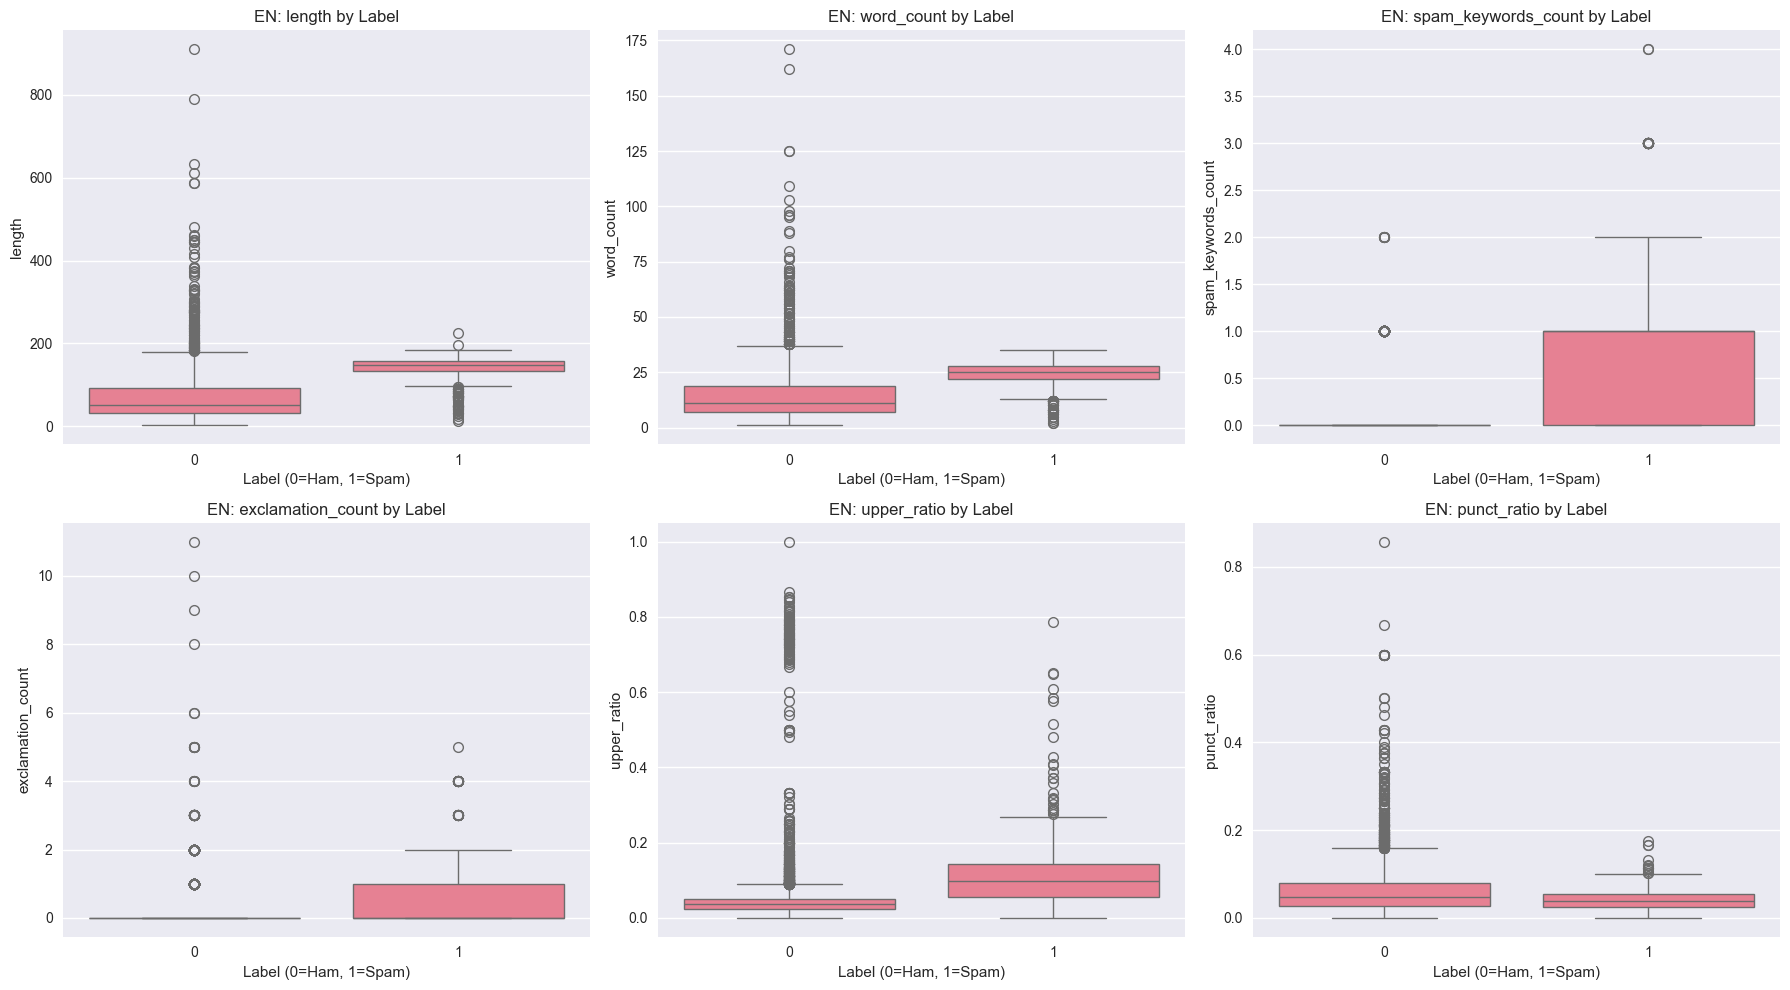


Extracting features for Sinhala dataset...


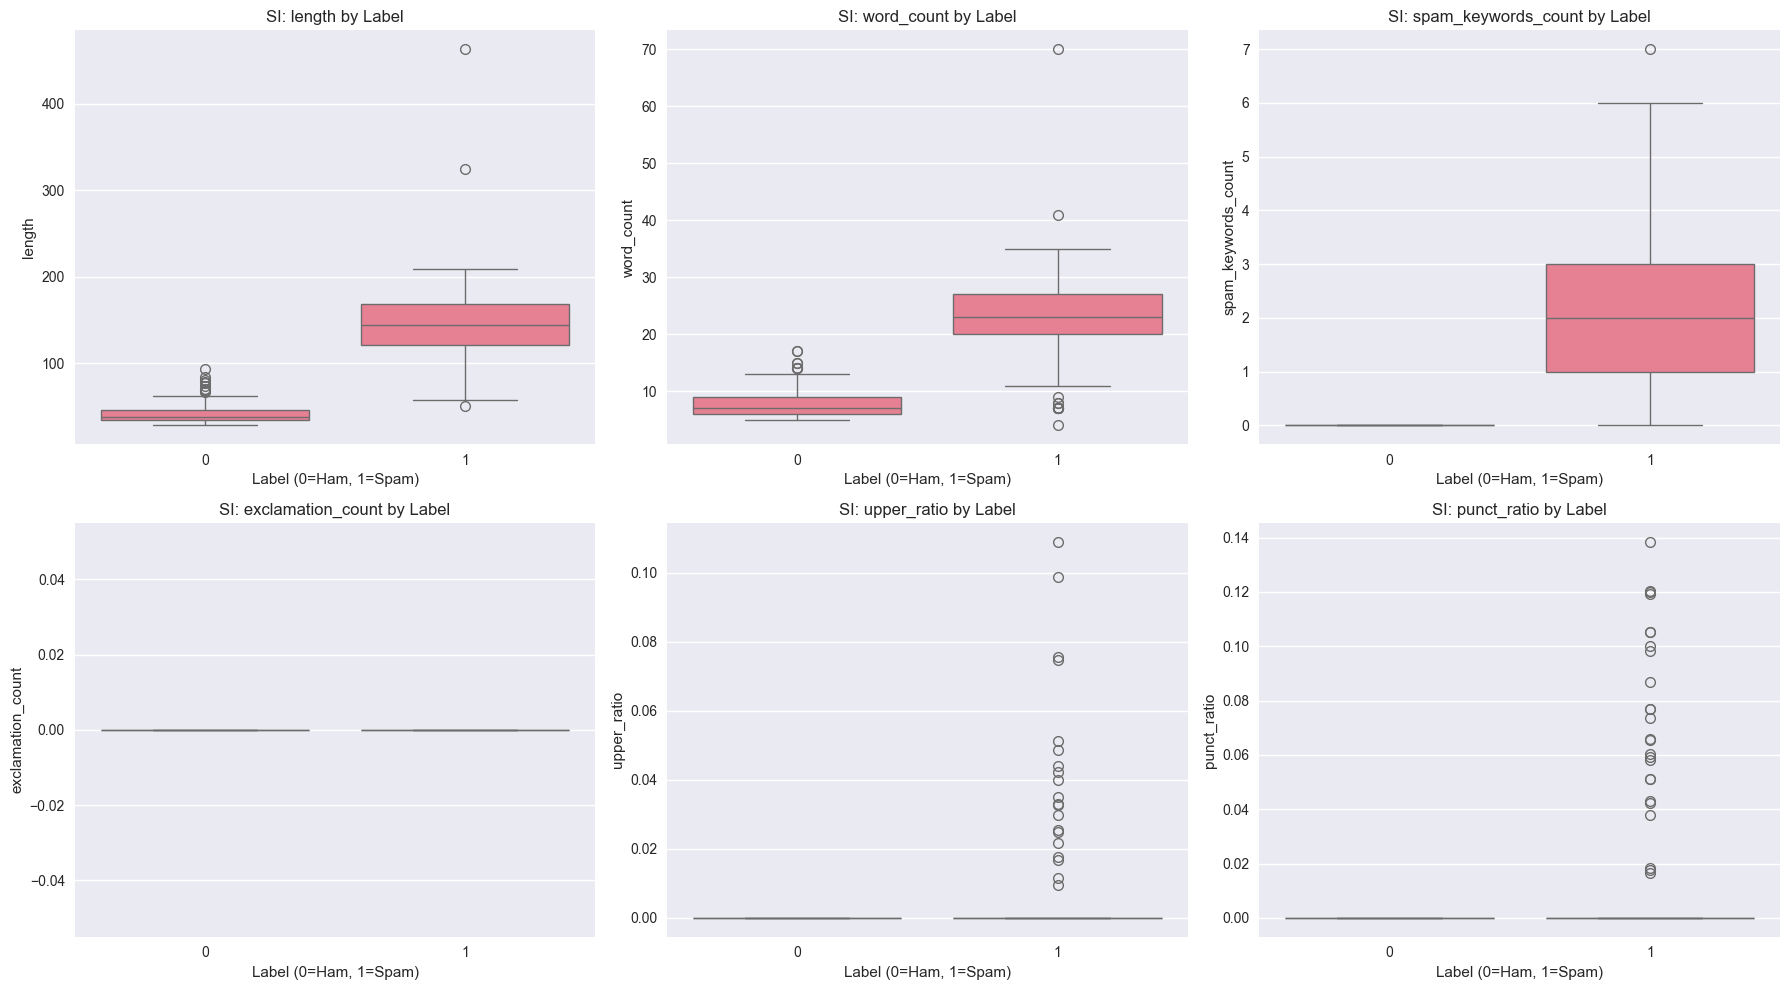

In [4]:
# ===============================================================================
# Cell 4: Feature Engineering

class FeatureExtractor:
    def __init__(self):
        pass
    
    def extract_features(self, text, language='en'):
        """Extract additional features from text"""
        text = str(text) if text is not None else ""
        
        features = {}
        
        # Basic text statistics
        features['length'] = len(text)
        features['word_count'] = len(text.split())
        features['char_count'] = len([c for c in text if c.isalpha()])
        features['digit_count'] = len([c for c in text if c.isdigit()])
        features['upper_case_count'] = len([c for c in text if c.isupper()])
        features['punctuation_count'] = len([c for c in text if c in string.punctuation])
        
        # Ratios (avoid division by zero)
        if len(text) > 0:
            features['digit_ratio'] = features['digit_count'] / len(text)
            features['upper_ratio'] = features['upper_case_count'] / len(text)
            features['punct_ratio'] = features['punctuation_count'] / len(text)
        else:
            features['digit_ratio'] = 0
            features['upper_ratio'] = 0
            features['punct_ratio'] = 0
            
        # Special characters
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['dollar_count'] = text.count('$')
        
        # Spam keywords
        spam_keywords_en = ['free', 'win', 'winner', 'cash', 'prize', 'urgent', 'congratulations', 
                           'offer', 'deal', 'discount', 'limited', 'act now', 'call now', 'click here']
        
        spam_keywords_si = ['නොමිලේ', 'ජයග්‍රහණය', 'ත්‍යාගය', 'මුදල්', 'හදිසි', 'සුභ පැතුම්', 
                           'දිනන', 'අවස්ථාවක්', 'ලක්ෂ', 'වාසියෙන්', 'තෝරාගෙන', 'බැංකු']
        
        if language == 'en':
            spam_words = spam_keywords_en
        else:
            spam_words = spam_keywords_si
            
        text_lower = text.lower()
        features['spam_keywords_count'] = sum(1 for word in spam_words if word in text_lower)
        
        return list(features.values())
    
    def visualize_features(self, df, language='en'):
        """Visualize extracted features"""
        # Extract features for all messages
        feature_data = []
        for _, row in df.iterrows():
            features = self.extract_features(row['Message'], language)
            features.append(row['Label'])
            feature_data.append(features)
        
        feature_names = ['length', 'word_count', 'char_count', 'digit_count', 'upper_case_count',
                        'punctuation_count', 'digit_ratio', 'upper_ratio', 'punct_ratio',
                        'exclamation_count', 'question_count', 'dollar_count', 'spam_keywords_count', 'label']
        
        feature_df = pd.DataFrame(feature_data, columns=feature_names)
        
        # Plot key features
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        key_features = ['length', 'word_count', 'spam_keywords_count', 'exclamation_count', 'upper_ratio', 'punct_ratio']
        
        for i, feature in enumerate(key_features):
            row, col = i // 3, i % 3
            sns.boxplot(data=feature_df, x='label', y=feature, ax=axes[row, col])
            axes[row, col].set_title(f'{language.upper()}: {feature} by Label')
            axes[row, col].set_xlabel('Label (0=Ham, 1=Spam)')
        
        plt.tight_layout()
        plt.show()
        
        return feature_df

# Extract and visualize features
feature_extractor = FeatureExtractor()
print("Extracting features for English dataset...")
eng_features = feature_extractor.visualize_features(eng_df, 'en')

print("\nExtracting features for Sinhala dataset...")
sin_features = feature_extractor.visualize_features(sin_df, 'si')


In [5]:
# Cell 5: Text Preprocessing

def preprocess_text(text, language='en'):
    """Basic text preprocessing"""
    text = str(text) if text is not None else ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
eng_df['processed_message'] = eng_df['Message'].apply(lambda x: preprocess_text(x, 'en'))
sin_df['processed_message'] = sin_df['Message'].apply(lambda x: preprocess_text(x, 'si'))

print("Text preprocessing completed!")

Text preprocessing completed!


In [6]:
# Cell 6: Model Training - English

def train_english_model(df):
    """Train English spam detection model"""
    print("Training English model...")
    
    # Prepare data
    X = df['processed_message']
    y = df['Label']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.95
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Train models
    models = {
        'Naive Bayes': MultinomialNB(alpha=0.1),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train_tfidf, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_tfidf)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        
        print(f"{name} Accuracy: {accuracy:.4f}")
    
    # Choose best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    
    return best_model, vectorizer, X_test, y_test, results

# Train English model
eng_model, eng_vectorizer, eng_X_test, eng_y_test, eng_results = train_english_model(eng_df)

Training English model...
Naive Bayes Accuracy: 0.9848
Random Forest Accuracy: 0.9776
Logistic Regression Accuracy: 0.9722

Best model: Naive Bayes


In [7]:
# Cell 7: Model Training - Sinhala

def train_sinhala_model(df):
    """Train Sinhala spam detection model"""
    print("Training Sinhala model...")
    
    # Prepare data
    X = df['processed_message']
    y = df['Label']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create TF-IDF vectorizer (character-based for Sinhala)
    vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(1, 3),
        max_features=3000,
        min_df=2,
        max_df=0.95
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Train models
    models = {
        'Naive Bayes': MultinomialNB(alpha=0.1),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train_tfidf, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_tfidf)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        
        print(f"{name} Accuracy: {accuracy:.4f}")
    
    # Choose best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    
    print(f"\nBest model: {best_model_name}")
    
    return best_model, vectorizer, X_test, y_test, results

# Train Sinhala model
sin_model, sin_vectorizer, sin_X_test, sin_y_test, sin_results = train_sinhala_model(sin_df)

Training Sinhala model...
Naive Bayes Accuracy: 1.0000
Random Forest Accuracy: 1.0000
Logistic Regression Accuracy: 1.0000

Best model: Naive Bayes


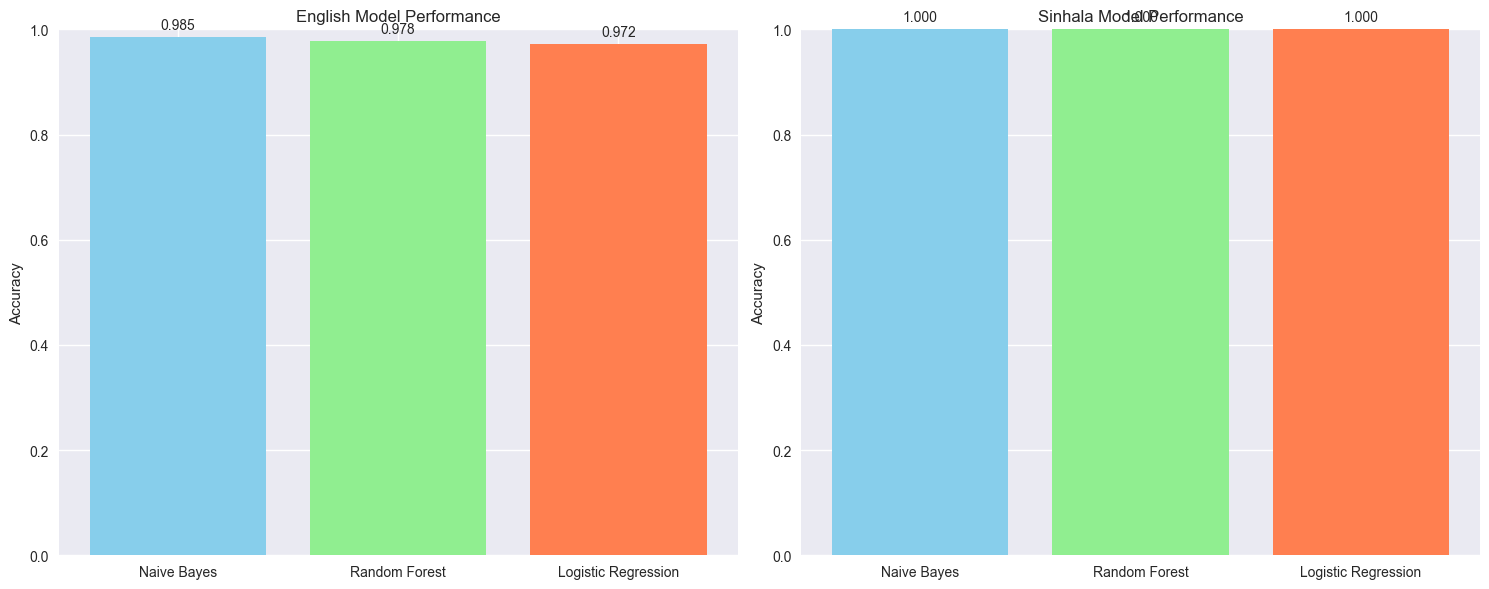

In [8]:
# Cell 8: Model Performance Visualization

def plot_model_performance():
    """Plot model performance comparison"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # English model performance
    models = list(eng_results.keys())
    accuracies = list(eng_results.values())
    
    bars1 = axes[0].bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral'])
    axes[0].set_title('English Model Performance')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
    
    # Sinhala model performance
    models = list(sin_results.keys())
    accuracies = list(sin_results.values())
    
    bars2 = axes[1].bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral'])
    axes[1].set_title('Sinhala Model Performance')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars2, accuracies):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_model_performance()

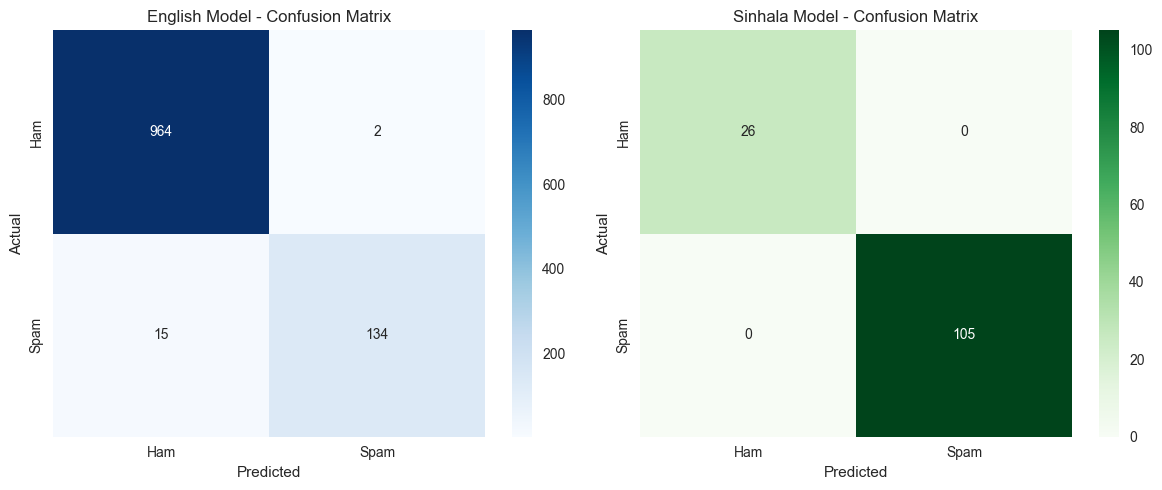

English Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115


Sinhala Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00       105

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131



In [9]:
# ===============================================================================
# Cell 9: Confusion Matrix Visualization

def plot_confusion_matrices():
    """Plot confusion matrices for both models"""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # English model confusion matrix
    eng_X_test_tfidf = eng_vectorizer.transform(eng_X_test)
    eng_y_pred = eng_model.predict(eng_X_test_tfidf)
    eng_cm = confusion_matrix(eng_y_test, eng_y_pred)
    
    sns.heatmap(eng_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('English Model - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticklabels(['Ham', 'Spam'])
    axes[0].set_yticklabels(['Ham', 'Spam'])
    
    # Sinhala model confusion matrix
    sin_X_test_tfidf = sin_vectorizer.transform(sin_X_test)
    sin_y_pred = sin_model.predict(sin_X_test_tfidf)
    sin_cm = confusion_matrix(sin_y_test, sin_y_pred)
    
    sns.heatmap(sin_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('Sinhala Model - Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_xticklabels(['Ham', 'Spam'])
    axes[1].set_yticklabels(['Ham', 'Spam'])
    
    plt.tight_layout()
    plt.show()
    
    # Print classification reports
    print("English Model Classification Report:")
    print(classification_report(eng_y_test, eng_y_pred))
    
    print("\nSinhala Model Classification Report:")
    print(classification_report(sin_y_test, sin_y_pred))

plot_confusion_matrices()

In [10]:
# ===============================================================================
# Cell 10: Prediction Function

def predict_spam(text, language='en'):
    """Predict if a message is spam or ham"""
    
    # Preprocess text
    processed_text = preprocess_text(text, language)
    
    if language == 'en':
        # Transform text using English vectorizer
        text_tfidf = eng_vectorizer.transform([processed_text])
        
        # Make prediction
        prediction = eng_model.predict(text_tfidf)[0]
        probability = eng_model.predict_proba(text_tfidf)[0]
        
    else:  # Sinhala
        # Transform text using Sinhala vectorizer
        text_tfidf = sin_vectorizer.transform([processed_text])
        
        # Make prediction
        prediction = sin_model.predict(text_tfidf)[0]
        probability = sin_model.predict_proba(text_tfidf)[0]
    
    result = "SPAM" if prediction == 1 else "HAM"
    confidence = max(probability)
    
    return result, confidence

In [11]:
# ===============================================================================
# Cell 11: Test the Models

def test_models():
    """Test the models with sample messages"""
    
    # Test messages
    test_messages = [
        ("Congratulations! You've won $1000! Click here now!", 'en'),
        ("Hi, how are you doing today?", 'en'),
        ("FREE OFFER! Limited time deal!", 'en'),
        ("Meeting at 3pm tomorrow", 'en'),
        ("නොමිලේ මුදල් දිනන අවස්ථාව!", 'si'),
        ("කොහොමද? කාලයක් වුණා හමුවෙලා", 'si'),
        ("ත්‍යාගය ලබාගන්න දැන්ම!", 'si'),
        ("හමුවීම හෙට 3 ට", 'si')
    ]
    
    print("Testing the models:\n")
    print("="*60)
    
    for message, lang in test_messages:
        result, confidence = predict_spam(message, lang)
        print(f"Language: {lang.upper()}")
        print(f"Message: '{message}'")
        print(f"Prediction: {result} (Confidence: {confidence:.4f})")
        print("-" * 60)

test_models()

Testing the models:

Language: EN
Message: 'Congratulations! You've won $1000! Click here now!'
Prediction: SPAM (Confidence: 0.9929)
------------------------------------------------------------
Language: EN
Message: 'Hi, how are you doing today?'
Prediction: HAM (Confidence: 0.9975)
------------------------------------------------------------
Language: EN
Message: 'FREE OFFER! Limited time deal!'
Prediction: HAM (Confidence: 0.9261)
------------------------------------------------------------
Language: EN
Message: 'Meeting at 3pm tomorrow'
Prediction: HAM (Confidence: 0.9972)
------------------------------------------------------------
Language: SI
Message: 'නොමිලේ මුදල් දිනන අවස්ථාව!'
Prediction: SPAM (Confidence: 0.9705)
------------------------------------------------------------
Language: SI
Message: 'කොහොමද? කාලයක් වුණා හමුවෙලා'
Prediction: HAM (Confidence: 1.0000)
------------------------------------------------------------
Language: SI
Message: 'ත්‍යාගය ලබාගන්න දැන්ම!'
Predicti

In [12]:
# ===============================================================================
# Cell 12: Save Models

def save_models():
    """Save the trained models"""
    try:
        joblib.dump(eng_model, 'english_spam_model.pkl')
        joblib.dump(sin_model, 'sinhala_spam_model.pkl')
        joblib.dump(eng_vectorizer, 'english_vectorizer.pkl')
        joblib.dump(sin_vectorizer, 'sinhala_vectorizer.pkl')
        
        print("Models saved successfully!")
        print("Files saved:")
        print("- english_spam_model.pkl")
        print("- sinhala_spam_model.pkl")
        print("- english_vectorizer.pkl")
        print("- sinhala_vectorizer.pkl")
        
    except Exception as e:
        print(f"Error saving models: {e}")

save_models()

print("\n" + "="*60)
print("SPAM DETECTION MODEL TRAINING COMPLETED!")
print("="*60)

Models saved successfully!
Files saved:
- english_spam_model.pkl
- sinhala_spam_model.pkl
- english_vectorizer.pkl
- sinhala_vectorizer.pkl

SPAM DETECTION MODEL TRAINING COMPLETED!
